### Simulaciones de trayectorías (plásticos)


## Introducción

Comprender las trayectorias en el océano es importante para varias aplicaciones, como la contaminación marina por plásticos, pero también para otros contaminantes oceánicos como los derrames de petróleo o para estudios de ecología marina para comprender la conectividad de las especies marinas. Las simulaciones Lagrangianas son una  herramienta potente para obtener trayectorias marinas. Una de las herramientas de software abierto que existen es OceanParcels. Usando como entrada campos de velocidad, como los que vimos en el tutorial anterior (por ejemplo, productos altimetría satelital de la superficie del mar), podemos obtener fácilmente trayectorias de partículas con diferentes características.

<!-- Here will look at an example of a Lagrangian simulation..... -->

¿Quieres saber más detalles sobre OceanParcels? Más info. [aquí](https://docs.oceanparcels.org/en/latest/index.html).


También puede explorar el simulador en línea [plastic adrift](https://plasticadrift.org/)!!

## ¿Cómo funciona?

### Características de la simulación:
* Duración (runtime): 10 días
* Número de partículas: 20 (1 línea longitudinal (norte-sur))

In [1]:
%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from glob import glob
import xarray as xr
from parcels import FieldSet, ParticleSet, ScipyParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')

In [2]:
import parcels
parcels.__version__ # para saber la versión del paquete parcels que estamos usando

'3.1.4'

# Campos de entrada (input fields):

Usaremos los campos de velocidad de derivados de datos de satélite obtenidos de la plataforma [Copernicus Marine Service](https://marine.copernicus.eu/).

In [3]:
filedir = '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/'

In [4]:
!ls /home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/

dt_global_allsat_phy_l4_20180901_20241017.nc
dt_global_allsat_phy_l4_20180902_20241017.nc
dt_global_allsat_phy_l4_20180903_20241017.nc
dt_global_allsat_phy_l4_20180904_20241017.nc
dt_global_allsat_phy_l4_20180905_20241017.nc
dt_global_allsat_phy_l4_20180906_20241017.nc
dt_global_allsat_phy_l4_20180907_20241017.nc
dt_global_allsat_phy_l4_20180908_20241017.nc
dt_global_allsat_phy_l4_20180909_20241017.nc
dt_global_allsat_phy_l4_20180910_20241017.nc
dt_global_allsat_phy_l4_20180911_20241017.nc
dt_global_allsat_phy_l4_20180912_20241017.nc
dt_global_allsat_phy_l4_20180913_20241017.nc
dt_global_allsat_phy_l4_20180914_20241017.nc
dt_global_allsat_phy_l4_20180915_20241017.nc


## Primero cargamos un fichero de ejemplo:

In [5]:
ds_m = xr.open_dataset(filedir + "dt_global_allsat_phy_l4_20180906_20241017.nc")


In [6]:
ds_m

<xarray.Dataset> Size: 332MB
Dimensions:         (latitude: 1440, nv: 2, longitude: 2880, time: 1)
Coordinates:
  * latitude        (latitude) float32 6kB -89.94 -89.81 -89.69 ... 89.81 89.94
  * nv              (nv) int32 8B 0 1
  * longitude       (longitude) float32 12kB -179.9 -179.8 ... 179.8 179.9
  * time            (time) datetime64[ns] 8B 2018-09-06
Data variables: (12/14)
    crs             int32 4B ...
    lat_bnds        (latitude, nv) float32 12kB ...
    lon_bnds        (longitude, nv) float32 23kB ...
    sla             (time, latitude, longitude) float64 33MB ...
    err_sla         (time, latitude, longitude) float64 33MB ...
    ugosa           (time, latitude, longitude) float64 33MB ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 33MB ...
    adt             (time, latitude, longitude) float64 33MB ...
    ugos            (time, latitude, longitude) float64 33MB ...
    vgos            (time, latitude, longitude) float64 33MB ...
    flag_ice        (time, latitude, longitude) float64 33MB ...
    tpa_correction  (time) float64 8B ...
Attributes: (12/42)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    geospatial_vertical_units:       m
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    time_coverage_end:               2018-09-06T12:00:00Z
    time_coverage_start:             2018-09-05T12:00:00Z
    platform:                        Cryosat-2, Altika Drifting Phase, Haiyan...

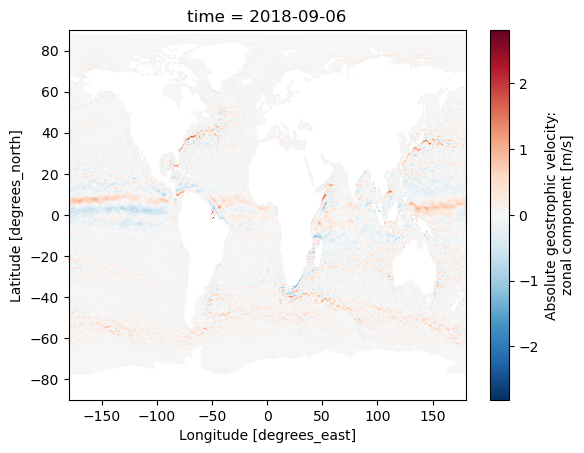

In [7]:
ds_m.ugos[0,:,:].plot()

## Seleccionamos una subzona:

In [8]:
lon_min = -100
lon_max = -75
lat_min = 2
lat_max = 10

In [9]:
ds_m_sub = ds_m.where((ds_m.longitude<lon_max)&(ds_m.longitude>lon_min)&(ds_m.latitude<lat_max)&(ds_m.latitude>lat_min), drop=True)


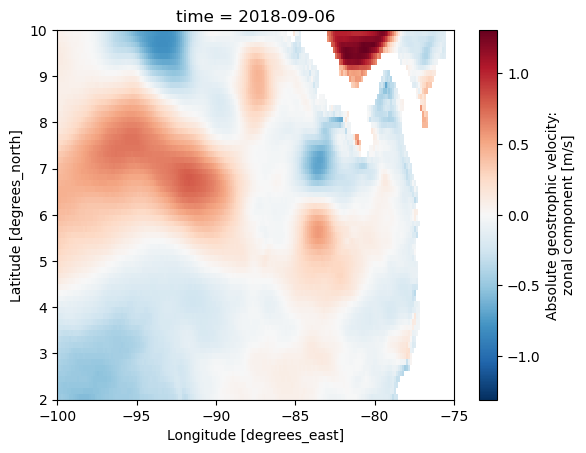

In [10]:
ds_m_sub.ugos[0,:,:].plot()

## Definimos el "fieldset" (campo de velocidad) para las simulaciones:

### Primero indicamos que ficheros usaremos para los campos de velocidad (indicando también el directorio, filedir):

In [11]:
ficheros = {'U': filedir + "dt_global_allsat_phy_l4_201809[0-1]?_*.nc",
            'V': filedir + "dt_global_allsat_phy_l4_201809[0-1]?_*.nc"}


"dt_global_allsat_phy_l4_201809[0-1]?_*.nc" para definir la lista de ficheros usamos expresiones regulares ("[0-1]" , "?", "*").  

El uso de estas expresiones regulares nos permite decir que vamos a usar una lista de ficheros.  Todos los ficheros correspondientes a esta expresión los podemos ver si hacemos :

In [12]:
!ls /home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_201809[0-1]?_*.nc

/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180901_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180902_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180903_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180904_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180905_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180906_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180907_20241017.nc
/home/jovyan/shared/datos_para_tutoriales/tutoriales/ta

Vemos que nos aparece una lista de ficheros que empiezan todos por "dt_global_allsat_phy_l4_201809" y a continuación siguen por 0 o 1 (la parte de [0-1]) cualquier otro dígito seguido por _ ("?_"), y luego el "*" para decir que cualquier digito a continuación seguido por ".nc" 

Para saber más sobre expresiones regulares pueden usar esta página: https://regex101.com/ . 

### Usamos la velocidad Euleriana, así que elegimos las variables ugos y vgos:

In [13]:
# Primero definimos el nombre de las variables que vamos a usar, en este caso especificamos que la velocidad zonal (U) en nuestro datos se llama 'ugos', y lo mismo para la velocidad meridional (V):
variables = {'U': 'ugos', 
             'V': 'vgos'} 

# Segundo, definimos el nombre de las dimensiones (variables de las que depende nuestras variables anteriores), en este caso la latitude (lat), longitud (lon) y el tiempo (time).
dimensiones = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

### Ahora ya tenemos todo los elementos necesarios para definir nuestro _fieldset_ :

In [14]:
fieldset = FieldSet.from_netcdf(ficheros, variables, dimensiones, deferred_load=False)

# Definimos los parámetros de la simulación:

## ¿Cuántas y dónde queremos lanzar las partículas?

### Opción A) Definimos las longitudes y latitudes.
### Por ejemple, lanzamos las partículas sobre una línea:

In [15]:
lat1D = np.arange(4, 6, .1) # (inicio, fin + incremento, incremento)
lon1D = np.ones_like(lat1D) * -90.

pset_A = ParticleSet(fieldset=fieldset, pclass=ScipyParticle, lon=lon1D, lat=lat1D)


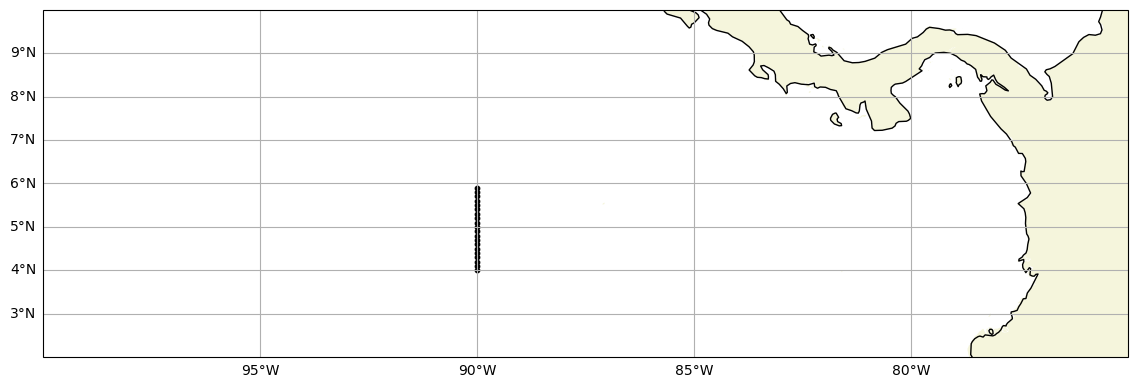

In [16]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='beige') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_A.lon, pset_A.lat, c='k', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


Para la gráfica usamos el paquete _cartopy_ . Esta herramienta fue presentada por Charles Troupin en el taller intermedio y pueden ver el material [aquí](https://github.com/Intercoonecta/Talleres_intermedios/blob/main/18-Octubre-2024/datos%20espaciales/datos_espaciales_cartopy.ipynb).

## Otros parámetros:

### Definimos cuanto queremos que dure nuestra simulación, en este caso elegimos 10 días:

In [17]:
runtime_days = 10 

## Simulación con set de partículas A:

In [18]:
fichero_salida_A = "lag_simu_pset_A_test01" # fichero guardado en formato .zarr que es equivalente a netcdf (.nc)

"Zarr es un formato de datos basado en la nube que mejora el acceso a los datos multidimensionales." (fuente: https://pro.arcgis.com/es/pro-app/latest/help/data/imagery/multidimensional-raster-types.htm)

Mas información aquí: https://www.inta.es/INTA/gl/blogs/copernicus/BlogEntry_1706695503125

In [19]:
output_file = pset_A.ParticleFile(name=fichero_salida_A, outputdt=timedelta(hours=24))
pset_A.execute(pset_A.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Output files are stored in lag_simu_pset_A_test01.zarr.
100%|██████████| 864000.0/864000.0 [00:14<00:00, 58023.54it/s]


In [20]:
!ls -trl # para ver los nuevos ficheros en nuestro directorio

total 1184
-rw-r--r--. 1 jovyan jovyan    525 Nov 20 09:59 README.md
drwxr-xr-x. 8 jovyan jovyan    126 Nov 24 12:39 lag_simu_pset_B_test01.zarr
-rw-r--r--. 1 jovyan jovyan 731480 Nov 24 12:41 simulaciones_trayectorias-plasticos_psetA.ipynb
-rw-r--r--. 1 jovyan jovyan 472403 Nov 24 12:42 simulaciones_trayectorias-plasticos_psetB.ipynb
drwxr-xr-x. 8 jovyan jovyan    126 Nov 24 12:42 lag_simu_pset_A_test01.zarr


"Si inicia una celda con !, el contenido de esta se ejecuta como un comando bash en el contenedor de su notebook." (fuente: https://enterprise.arcgis.com/es/notebook/latest/use/windows/essential-notebook-commands.htm)

# Echemos un vistazo a las trayectorias generadas:

In [21]:
ds = xr.open_dataset("lag_simu_pset_A_test01.zarr", engine="zarr")

In [22]:
ds

<xarray.Dataset> Size: 4kB
Dimensions:     (trajectory: 20, obs: 10)
Coordinates:
  * trajectory  (trajectory) int64 160B 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * obs         (obs) int32 40B 0 1 2 3 4 5 6 7 8 9
Data variables:
    lat         (trajectory, obs) float32 800B ...
    lon         (trajectory, obs) float32 800B ...
    time        (trajectory, obs) datetime64[ns] 2kB ...
    z           (trajectory, obs) float32 800B ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ScipyParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.1.4

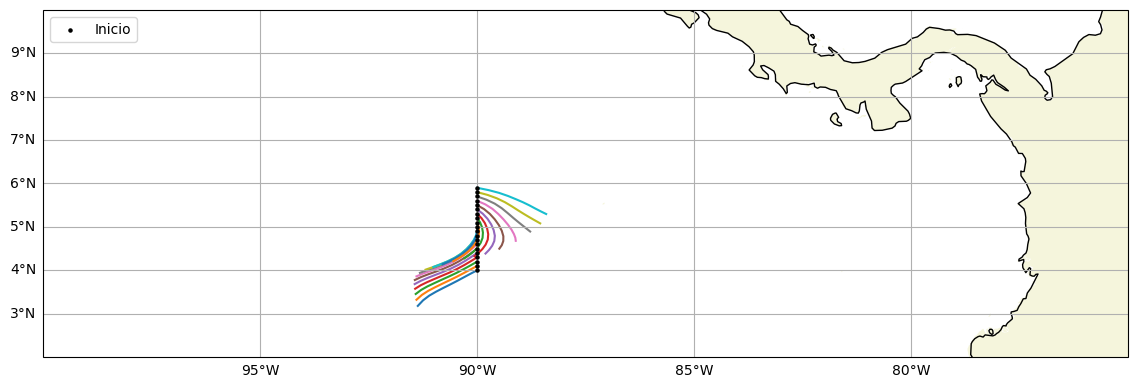

In [23]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='beige') # si el codigo tarda mucho, se puede comentar esta línea

# Partículas al inicio:
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Inicio', zorder=20)

# Trayectorias de las partículas:
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())

# Añadimos los límites al mapa:
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])

# Añadimos la leyenda:
ax1.legend(loc=2)

# Gridlines
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Graficamos las partículas con los campos de velocidad de fondo:

### Cargamos las velocidades para todos los días:

In [24]:
ficheros = sorted(glob(filedir + "dt_global_allsat_phy_l4_201809[0-1]*.nc"))
ficheros = ficheros[0:10]
ficheros

['/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180901_20241017.nc',
 '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180902_20241017.nc',
 '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180903_20241017.nc',
 '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180904_20241017.nc',
 '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180905_20241017.nc',
 '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180906_20241017.nc',
 '/home/jovyan/shared/datos_para_tutoriales/tutoriales/taller_corrientes_y_plasticos_python/dt_global_allsat_phy_l4_20180907_20241017.nc',
 '/home/jovyan/shared/datos

In [25]:
ds_m_all = xr.open_mfdataset(ficheros)

### Graficamos en el primer paso de tiempo con la velocidad zonal de fondo:

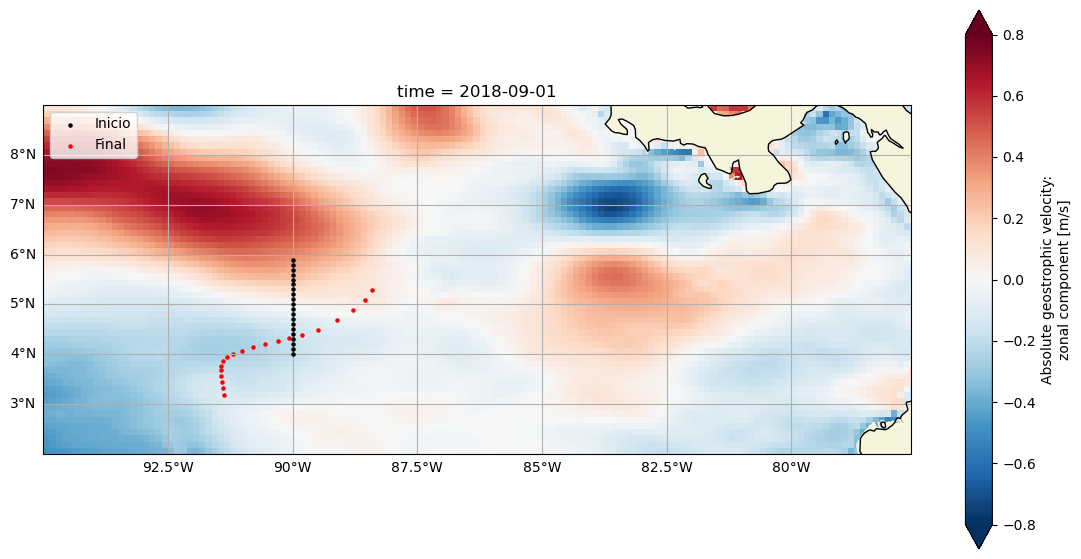

In [26]:
plt.figure(figsize=(14,7))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())

# Graficamos las velocidades:
ds_m_all.ugos[0,:,:].plot(vmin=-.8, vmax=.8, cmap='RdBu_r', transform=ccrs.PlateCarree(), zorder=1)

# Añadimos la tierra
ax1.coastlines(resolution='50m', zorder=3)
ax1.add_feature(cartopy.feature.LAND, facecolor='beige', zorder=2) # si el codigo tarda mucho, se puede comentar esta línea

# Partículas al inicio 
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Inicio',zorder=20)
# Partículas al final
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=5, transform=ccrs.PlateCarree(), label='Final')

# Añadimos los límites al mapa:
ax1.set_xlim([-95, -77.6])
ax1.set_ylim([lat_min, 9])

# Añadimos la leyenda:
ax1.legend(loc=2)

# Gridlines:
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### Graficamos en el último paso de tiempo con la velocidad meridional de fondo:

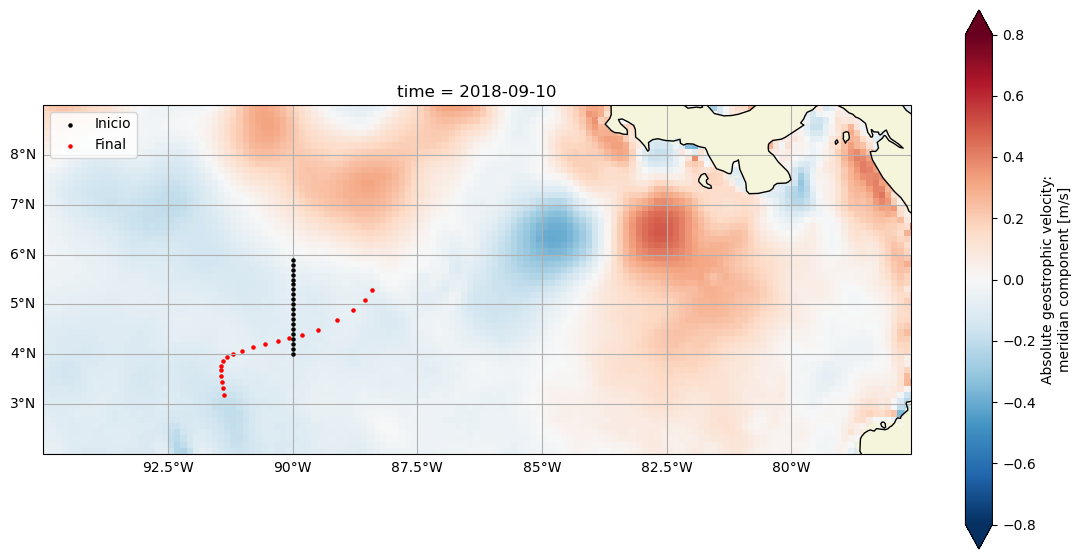

In [27]:
plt.figure(figsize=(14,7))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())

# Graficamos las velocidades:
ds_m_all.vgos[-1,:,:].plot(vmin=-.8, vmax=.8, cmap='RdBu_r', transform=ccrs.PlateCarree(), zorder=1)

# Añadimos la tierra
ax1.coastlines(resolution='50m', zorder=3)
ax1.add_feature(cartopy.feature.LAND, facecolor='beige', zorder=2) # si el codigo tarda mucho, se puede comentar esta línea

# Partículas al inicio 
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Inicio',zorder=20)
# Partículas al final
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=5, transform=ccrs.PlateCarree(), label='Final')

# Añadimos los límites al mapa:
ax1.set_xlim([-95, -77.6])
ax1.set_ylim([lat_min, 9])

# Añadimos la leyenda:
ax1.legend(loc=2)

# Gridlines:
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Referencias

Laura Gomez-Navarro, & Paul Hargous. (2024). IMEDEA-AP-LAB/MASS24_Altimetry_tutorial: v1.0.0 (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.13962687